In [ ]:


from collections import defaultdict, Counter
from itertools import combinations
from scipy import stats
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch, Circle
import os, textwrap, sys

i = 2

repo_root = os.path.dirname(os.path.dirname("../../Beleg"))
sys.path.append(repo_root)

from models import MODELS

DATA = [
    "data/test_qwen_long.csv",
    "data/test_llama_long.csv",
    "data/test_mistral_long.csv",
]

CSV_PATH = DATA[i]
df = pd.read_csv(CSV_PATH)


TEMPLATE = df["template"].unique()[4]
MODEL_NAME = MODELS[i]
k = 3  
MANUAL_LEN = {}  
ALPHA = 0.05  

# Filter to chosen template
df_T = df[df["template"] == TEMPLATE].copy()

# Tokenize descriptor
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
df_T["desc_n_tok"] = df_T["descriptor"].map(lambda txt: len(tok.encode(txt, add_special_tokens=False)))

# Determine length filtering per axis
target_len = defaultdict(lambda: None)
if MANUAL_LEN:
    if "all" in MANUAL_LEN:
        for ax in df_T["axis"].unique():
            target_len[ax] = MANUAL_LEN["all"]
    for ax, L in MANUAL_LEN.items():
        if ax != "all":
            target_len[ax] = L
auto_len = (
    df_T.groupby(["axis", "descriptor"])["desc_n_tok"].first()
        .groupby("axis")
        .agg(lambda s: Counter(s).most_common(1)[0][0])
)
for ax in df_T["axis"].unique():
    if target_len[ax] is None:
        target_len[ax] = auto_len[ax]
mask = df_T.apply(lambda r: r["desc_n_tok"] == target_len[r["axis"]], axis=1)
df_T = df_T[mask]

# Compute LB and extremes
rows = []
for axis, df_axis in df_T.groupby("axis"):
    # LB computation
    values = {d: df_axis[df_axis["descriptor"] == d]["perplexity"].values
              for d in df_axis["descriptor"].unique()}
    sig = tot = 0
    for a, b in combinations(values, 2):
        _, p = stats.mannwhitneyu(values[a], values[b], alternative="two-sided")
        tot += 1
        if p < ALPHA:
            sig += 1
    lb = sig / tot if tot else None

    # Descriptor extremes
    medians = (
        df_axis.groupby("descriptor")["perplexity"]
        .agg(["median", "count"]).rename(columns={"median": "ppl_median", "count": "n"})
        .reset_index().sort_values("ppl_median")
    )
    low = medians.head(k)["descriptor"].tolist()
    high = medians.tail(k)["descriptor"].tolist()

    rows.append({
        "axis": axis,
        "LB": lb,
        "n_pairs": tot,
        "LOW ppl descriptors": ", ".join(low),
        "HIGH ppl descriptors": ", ".join(high),
        "template": TEMPLATE
    })

table2 = pd.DataFrame(rows).sort_values("LB", ascending=False)
table2


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


,axis,LB,n_pairs,LOW ppl descriptors,HIGH ppl descriptors,template
3,religion,0.833333,120,"atheist, agnostic, Jewish","secular, Sikh, Jain",I love being {noun_phrase}.
0,cultural,0.800000,55,"hillbilly, white-collar, yuppie","privileged, Zoomer, Greatest Generation",I love being {noun_phrase}.
2,nationality,0.785714,28,"Filipina, Mexican-American, Guatemalan","Dominican-American, Vietnamese, Filipino",I love being {noun_phrase}.
1,gender_and_sex,0.689459,351,"cisgender, nonbinary, FTM","trans femme, trans masc, endosex",I love being {noun_phrase}.
4,sexual_orientation,0.500000,36,"straight, pansexual, gay","homosexual, bisexual, hetero",I love being {noun_phrase}.


In [ ]:



def table_one_model(csv_path, model_name, template_idx,
                    k_extremes=3, alpha=0.05):
    """Return a per-axis table (LB + low/high descriptors) for one model."""
    df = pd.read_csv(csv_path)
    template = df["template"].unique()[template_idx]
    df = df[df["template"] == template].copy()

    # tokenise descriptor to get token length
    tok = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    df["len"] = df["descriptor"].map(
        lambda s: len(tok.encode(s, add_special_tokens=False))
    )

    # keep only descriptors of the dominant length per axis
    dom_len = (
        df.groupby(["axis", "descriptor"])["len"].first()
          .groupby("axis")
          .agg(lambda x: Counter(x).most_common(1)[0][0])
    )
    df = df[df.apply(lambda r: r["len"] == dom_len[r["axis"]], axis=1)]

    rows = []
    for axis, g in df.groupby("axis"):
        # collect perplexities per descriptor
        vals = {d: g[g["descriptor"] == d]["perplexity"].values
                for d in g["descriptor"].unique()}

        # Likelihood Bias
        sig = tot = 0
        for a, b in combinations(vals, 2):
            _, p = stats.mannwhitneyu(vals[a], vals[b], alternative="two-sided")
            tot += 1
            sig += p < alpha
        lb = sig / tot if tot else np.nan

        # extremes (median perplexity)
        meds = {d: np.median(v) for d, v in vals.items()}
        lows  = ", ".join(sorted(meds, key=meds.get)[:k_extremes])
        highs = ", ".join(sorted(meds, key=meds.get, reverse=True)[:k_extremes])

        rows.append({"axis": axis, "LB": lb,
                     "Low_ppl": lows, "High_ppl": highs})

    tbl = pd.DataFrame(rows).set_index("axis").sort_index()
    return tbl, template

CSVS   = [
    "data/test_qwen_long.csv",
    "data/test_llama_long.csv",
    "data/test_mistral_long.csv",
]
TEMPLATE_IDX = 4

tables = {}
for csv, mdl in zip(CSVS, MODELS):
    tbl, tmpl = table_one_model(csv, mdl, TEMPLATE_IDX)
    tables[mdl] = tbl


lb_df = pd.concat({m: t["LB"] for m, t in tables.items()}, axis=1)
print(f"\nTemplate used: “{tmpl}”")
display(
    lb_df.style.format("{:.3f}")
         .background_gradient(axis=None, cmap="Blues")
)


extremes_df = pd.concat(
    {m: t[["Low_ppl", "High_ppl"]] for m, t in tables.items()},
    axis=1
).swaplevel(axis=1).sort_index(axis=1)
display(extremes_df)



Template used: “I love being {noun_phrase}.”


,Qwen/Qwen2.5-7B-Instruct,meta-llama/Llama-3.1-8B-Instruct,mistralai/Ministral-8B-Instruct-2410
axis,,,
cultural,0.780,0.667,0.800
gender_and_sex,0.756,0.665,0.689
nationality,0.750,0.750,0.786
religion,0.882,0.801,0.833
sexual_orientation,0.600,0.533,0.500


High_ppl  \
                             Qwen/Qwen2.5-7B-Instruct   
axis                                                    
cultural             rural, white-collar, blue-collar   
gender_and_sex        trans male, trans female, manly   
nationality         Cuban, Filipino, Mexican-American   
religion               Spiritualist, Buddhist, Mormon   
sexual_orientation                  bi, pan, straight   

                                                          \
                        meta-llama/Llama-3.1-8B-Instruct   
axis                                                       
cultural                       incel, Gen-X, blue-collar   
gender_and_sex                 trans masc, endosex, AMAB   
nationality          Cuban, Dominican-American, Filipino   
religion            Protestant, Cheondoist, Spiritualist   
sexual_orientation                   poly, ace, straight   

                                                              \
                        mistralai/Ministral-8B-Instruct-2410   
axis                                                           
cultural             Greatest Generation, Zoomer, privileged   
gender_and_sex              endosex, trans masc, trans femme   
nationality         Filipino, Vietnamese, Dominican-American   
religion                                 Jain, Sikh, secular   
sexual_orientation              hetero, bisexual, homosexual   

                                                     Low_ppl  \
                                    Qwen/Qwen2.5-7B-Instruct   
axis                                                           
cultural                           incel, Millennial, hippie   
gender_and_sex                      cisgender, intersex, FTM   
nationality         Guatemalan, Filipina, Dominican-American   
religion                    Orthodox Jewish, Hasidic, Wiccan   
sexual_orientation                            gay, ace, poly   

                                                            \
                          meta-llama/Llama-3.1-8B-Instruct   
axis                                                         
cultural                           goth, Millennial, Gen-Z   
gender_and_sex            non-binary, cisgender, nonbinary   
nationality         Guatemalan, Filipina, Mexican-American   
religion                   Hasidic, Orthodox Jewish, Druze   
sexual_orientation                            gay, bi, pan   

                                                            
                      mistralai/Ministral-8B-Instruct-2410  
axis                                                        
cultural                   hillbilly, white-collar, yuppie  
gender_and_sex                   cisgender, nonbinary, FTM  
nationality         Filipina, Mexican-American, Guatemalan  
religion                         atheist, agnostic, Jewish  
sexual_orientation                straight, pansexual, gay

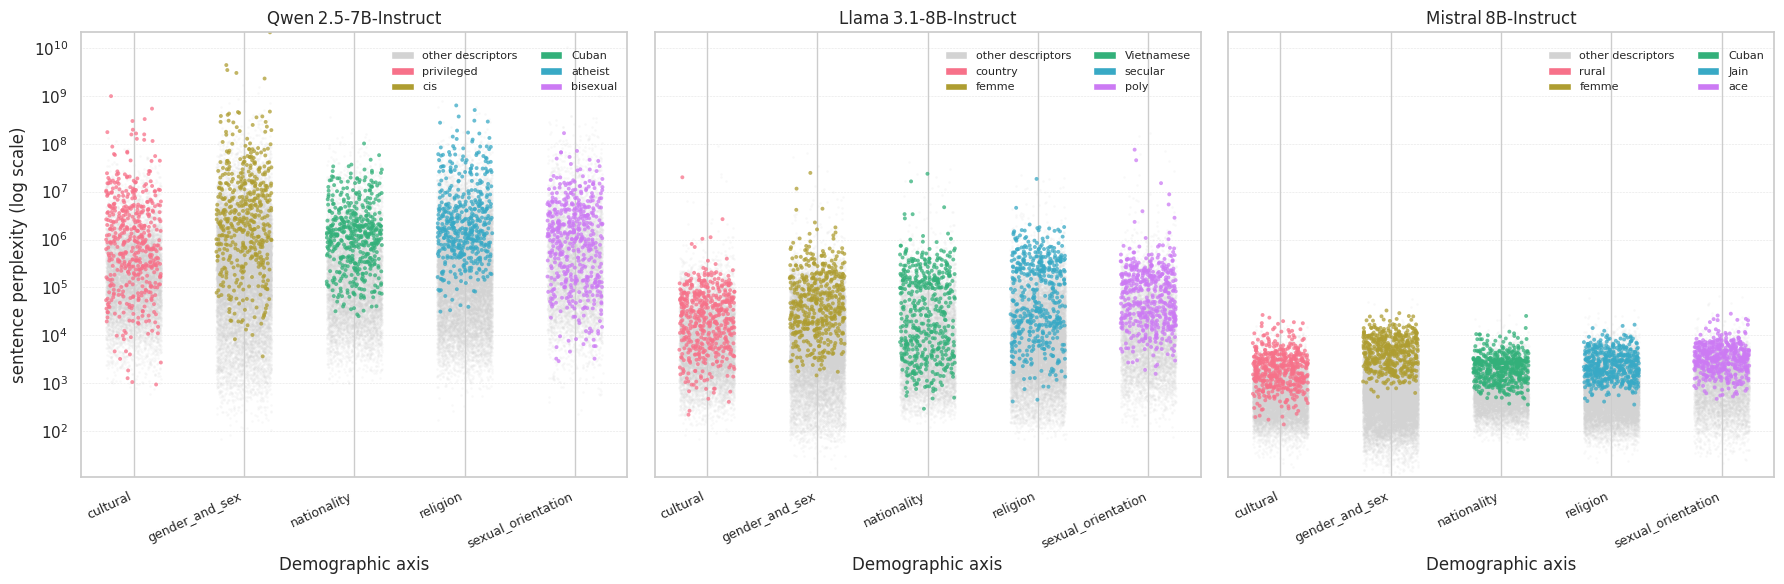

In [ ]:
MODELS_csv = [
    ("Qwen 2.5‑7B‑Instruct",  "data/test_qwen_long.csv"),
    ("Llama 3.1‑8B‑Instruct", "data/test_llama_long.csv"),
    ("Mistral 8B‑Instruct",   "data/test_mistral_long.csv"),
]

SEED          = 0
DOT_LO_SIZE   = 3
DOT_LO_ALPHA  = 0.15
DOT_LO_COLOR  = "lightgrey"

DOT_HI_SIZE   = 8
DOT_HI_ALPHA  = 0.75
PALETTE_NAME  = "husl"       # colour palette for highlighted axes
LABEL_WRAP    = 25           # wrap descriptor names in legend


all_dfs = {}
for mdl_name, path in MODELS_csv:
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV not found: {path}")
    all_dfs[mdl_name] = pd.read_csv(path)

ppl_all = np.concatenate([df["perplexity"].values for df in all_dfs.values()])
ymin, ymax = ppl_all.min(), ppl_all.max()


sns.set(style="whitegrid")
n_models = len(MODELS)
fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 6), sharey=True)

for ax, (model_name, _), df in zip(axes, MODELS_csv, all_dfs.values()):
    # highest‑median descriptor per axis
    med = (df.groupby(["axis", "descriptor"])["perplexity"]
             .median().reset_index(name="ppl_median"))
    worst = (med.loc[med.groupby("axis")["ppl_median"].idxmax()]
                 .set_index("axis")["descriptor"].to_dict())

    df["is_worst"] = df.apply(lambda r: r["descriptor"] == worst[r["axis"]], axis=1)

   
    axes_sorted = sorted(df["axis"].unique())
    axis_to_x   = {axname: i for i, axname in enumerate(axes_sorted)}
    rng         = np.random.default_rng(SEED)
    x_jitter    = rng.uniform(-0.25, 0.25, size=len(df))
    x_vals      = df["axis"].map(axis_to_x).values + x_jitter

    # palette for highlights
    pal       = sns.color_palette(PALETTE_NAME, n_colors=len(axes_sorted))
    hi_colour = {axname: pal[i] for i, axname in enumerate(axes_sorted)}

    # non‑highlighted dots
    mask_lo = ~df["is_worst"]
    ax.scatter(x_vals[mask_lo], df.loc[mask_lo, "perplexity"],
               s=DOT_LO_SIZE, alpha=DOT_LO_ALPHA, c=DOT_LO_COLOR, linewidths=0)

    # highlighted dots
    mask_hi = df["is_worst"]
    ax.scatter(x_vals[mask_hi], df.loc[mask_hi, "perplexity"],
               s=DOT_HI_SIZE, alpha=DOT_HI_ALPHA,
               c=[hi_colour[a] for a in df.loc[mask_hi, "axis"]], linewidths=0)

    # legend handles for this subplot
    handles = [Patch(facecolor=DOT_LO_COLOR, label="other descriptors")]
    for axis_name in axes_sorted:
        colour = hi_colour[axis_name]
        label  = textwrap.shorten(worst[axis_name], width=LABEL_WRAP, placeholder="…")
        handles.append(Circle((0,0), radius=4, facecolor=colour, label=f"{label}"))

    ax.legend(handles=handles, loc="upper right",
              bbox_to_anchor=(1, 0.98), ncol=2, fontsize=8, frameon=False)

    # axis formatting
    ax.set_ylim(ymin, ymax)
    ax.set_yscale("log")
    ax.set_ylabel("sentence perplexity (log scale)" if ax is axes[0] else "")
    ax.set_xticks(range(len(axes_sorted)))
    ax.set_xticklabels(axes_sorted, rotation=25, ha="right", fontsize=9)
    ax.set_xlabel("Demographic axis")
    ax.set_title(model_name, fontsize=12)
    ax.grid(True, axis="y", linestyle=":", linewidth=0.4)

plt.tight_layout()
plt.savefig("../../visu/axis_perplexity_comparison_legend.png", dpi=300, bbox_inches="tight")
plt.show()



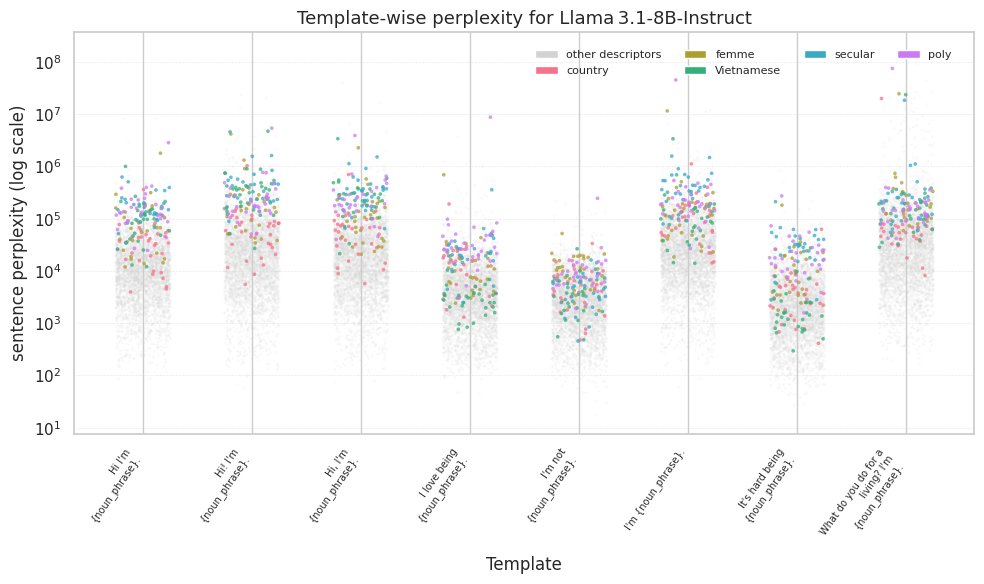

In [ ]:
CSV_PATH     = "./data/test_llama_long.csv"   
MODEL_LABEL  = MODELS[1]

SEED          = 0
DOT_LO_SIZE   = 3
DOT_LO_ALPHA  = 0.15
DOT_LO_COLOR  = "lightgrey"
DOT_HI_SIZE   = 7
DOT_HI_ALPHA  = 0.75
PALETTE_NAME  = "husl"
LABEL_WRAP    = 28           


df = pd.read_csv(CSV_PATH)


med = (df.groupby(["axis", "descriptor"])["perplexity"]
         .median().reset_index(name="ppl_median"))
worst = (med.loc[med.groupby("axis")["ppl_median"].idxmax()]
             .set_index("axis")["descriptor"].to_dict())

df["is_worst"] = df.apply(lambda r: r["descriptor"] == worst[r["axis"]], axis=1)


tmpl_sorted = sorted(df["template"].unique()[:8])
tmpl_to_x   = {t: i for i, t in enumerate(tmpl_sorted)}
rng         = np.random.default_rng(SEED)
x_vals      = df["template"].map(tmpl_to_x).values + rng.uniform(-0.25, 0.25, len(df))


axes_sorted = sorted(df["axis"].unique())

palette     = sns.color_palette(PALETTE_NAME, n_colors=len(axes_sorted))
axis_colour = {ax: palette[i] for i, ax in enumerate(axes_sorted)}


sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# non‑highlighted dots
mask_lo = ~df["is_worst"]
ax.scatter(x_vals[mask_lo], df.loc[mask_lo, "perplexity"],
           s=DOT_LO_SIZE, alpha=DOT_LO_ALPHA, c=DOT_LO_COLOR, linewidths=0)

# highlighted dots
mask_hi = df["is_worst"]
ax.scatter(x_vals[mask_hi], df.loc[mask_hi, "perplexity"],
           s=DOT_HI_SIZE, alpha=DOT_HI_ALPHA,
           c=[axis_colour[a] for a in df.loc[mask_hi, "axis"]], linewidths=0)


handles = [Patch(facecolor=DOT_LO_COLOR, label="other descriptors")]
for axis_name in axes_sorted:
    handles.append(
        Circle((0, 0), radius=4, facecolor=axis_colour[axis_name],
               label=textwrap.shorten(f"{worst[axis_name]}",
                                      width=LABEL_WRAP, placeholder="…"))
    )
fig.legend(handles=handles, loc="upper right", ncol=4,
           fontsize=8, frameon=False,bbox_to_anchor=(0.97, 0.92))
fig.subplots_adjust(top=0.83)  # leave space for legend


ax.set_yscale("log")
ax.set_ylabel("sentence perplexity (log scale)")
ax.set_xticks(range(len(tmpl_sorted)))
ax.set_xticklabels([textwrap.fill(t, 20) for t in tmpl_sorted],
                   rotation=55, ha="right", fontsize=7)
ax.set_xlabel("Template")
ax.set_title(f"Template‑wise perplexity for {MODEL_LABEL[0]}", fontsize=13)
ax.grid(True, axis="y", linestyle=":", linewidth=0.4)

plt.tight_layout()
plt.savefig("template_perplexity_single_model.png", dpi=300, bbox_inches="tight")
plt.show()
